In [45]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler


df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
df = df.groupby(by=["periodo","product_id"]).agg({"tn":"sum"}).reset_index()
df = df[~df["periodo"].isin([201911, 201912])]
df_kgl = df.pivot(index="product_id", columns="periodo", values="tn").fillna(0)
df_test = df[df["periodo"] == 201912].copy()
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df_pivot = df.pivot(index="product_id", columns="periodo", values="tn").fillna(0)

del df
gc.collect()


# --- FILTRAR PRODUCTOS CON AL MENOS 3 MESES DE ANTIGÜEDAD ---
# Opción 1: Al menos 3 meses con datos (no necesariamente consecutivos)
productos_con_3_meses = (df_pivot > 0).sum(axis=1) >= 3
df_pivot = df_pivot[productos_con_3_meses]
print(f"Shape de la matriz: {df_pivot.shape}")  # (800 productos x 36 meses)

Shape de la matriz: (1156, 34)


In [46]:
df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")# Verificar si el mes 20127 está presente
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df[df["product_id"]==20127]

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
2732958,2019-09-01,10217,20127,0,1,0.12322,0.12322
2732959,2019-09-01,10109,20127,0,1,0.61612,0.61612
2732960,2019-09-01,10027,20127,0,4,6.04913,6.04913
2732961,2019-09-01,10343,20127,0,1,0.04481,0.04481
2732962,2019-09-01,10208,20127,0,1,0.12322,0.12322
...,...,...,...,...,...,...,...
2941559,2019-12-01,10175,20127,0,1,0.36967,0.36967
2941560,2019-12-01,10236,20127,0,1,1.72512,1.72512
2941561,2019-12-01,10092,20127,0,1,0.56011,0.56011
2941562,2019-12-01,10473,20127,0,1,0.03361,0.03361


HIPERPARAMETROS

In [47]:
window_size = 12  # Ventana de  meses
scaler_name = "robust"  # "standard" o "robust"



In [48]:

scalers = {}  # Guardamos los scalers para invertir luego
scaled_data = np.zeros_like(df_pivot.values)

for i, (producto, fila) in enumerate(df_pivot.iterrows()):
    scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
    scaled_data[i] = scaler.fit_transform(fila.values.reshape(-1, 1)).flatten()
    scalers[producto] = scaler  # Almacenar scaler para este producto

In [49]:
X, y, productos = [], [], []

for i_producto, producto in enumerate(df_pivot.index):
    serie = scaled_data[i_producto]
    for i in range(window_size, len(serie) - 2):  # Asegurar que t+2 exista
        X.append(serie[i-window_size:i].reshape(-1, 1))  # Shape: (12, 1)
        y.append(serie[i+2])  # t+2 (i+1 es el offset desde el fin de la ventana)
        productos.append(producto)  # Identificador del producto

X = np.array(X)  # Shape: (n_muestras, 12, 1)
X = X.reshape(X.shape[0], X.shape[1])
y = np.array(y).reshape(-1, 1)  # Shape: (n_muestras, 1)

In [50]:
from sklearn.model_selection import train_test_split
magicos = [ 20002, 20003, 20006, 20010, 20011, 20018, 20019, 20021,
   20026, 20028, 20035, 20039, 20042, 20044, 20045, 20046,  20049,
   20051, 20052, 20053, 20055, 20008, 20001, 20017, 20086, 20180,
   20193, 20320, 20532, 20612, 20637, 20807, 20838
 ]
productos_unicos = df_pivot.index.unique()
productos_train = magicos

# # Máscaras para filtrar
# train_mask = [p in productos_unicos for p in magicos]
# test_mask = [p in productos_unicos for p in productos_unicos]

X_train, X_test = X[magicos], X[productos_unicos]
y_train, y_test = y[magicos], y[productos_unicos]

In [51]:
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

In [52]:
reg_model.coef_

array([[-0.31384948, -0.38057991,  0.54330097,  0.64773207, -0.47393703,
         0.39331709, -0.22958544,  0.17008053, -0.53690246, -0.01169518,
         0.05531851,  0.53566013]])

In [ ]:
def predecir_t2(product_id, ultimos_12_meses):
    scaler = scalers[product_id]
    ultimos_12_scaled = scaler.transform(np.array(ultimos_12_meses).reshape(-1, 1)).flatten()
    X_new = ultimos_12_scaled.reshape(1, -1)
    y_pred_scaled = reg_model.predict(X_new)
    return (y_pred_scaled * scaler.scale_) + scaler.center_

In [64]:
productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")
productos_ok = productos_ok["product_id"].unique()

def predecir_todos(productos_a_predecir):
    predicciones = {}
    for producto in productos_a_predecir:
        try:
            ultimos_12 = df_kgl.loc[producto].iloc[-window_size:].values
            prediccion = predecir_t2(producto, ultimos_12)
            predicciones[producto] = prediccion[0][0]
        except:
            predicciones[producto] = 0
    return predicciones
predicciones = predecir_todos(productos_ok)
predicciones_df = pd.DataFrame.from_dict(predicciones, orient='index', columns=['prediccion_t2'])
predicciones_df.index.name = 'product_id'
predicciones_df.reset_index(inplace=True)
predicciones_df

,product_id,prediccion_t2
0,20001,1055.826788
1,20002,1514.364690
2,20003,1010.578102
3,20004,692.535635
4,20005,715.151870
...,...,...
775,21263,-0.116834
776,21265,0.344052
777,21266,0.332456
778,21267,0.109126


In [65]:
print(20127 in df_pivot.index)

False


In [66]:
predicciones_df.columns = ["product_id", "tn"]
predicciones_df.to_csv("../results/reg_lineal.csv", index=False, sep=",")

In [22]:
df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
df = df.groupby(by=["periodo","product_id"]).agg({"tn":"sum"}).reset_index()
df_test = df[df["periodo"] == 201912].copy()

In [23]:
df_final = df_test.merge(predicciones_df, on="product_id", how="left")
# df_final.to_csv("LSTM_2_test.csv", index=False, sep=",")

In [24]:
df_final

,periodo,product_id,tn,y_pred
0,201912,20001,1504.68856,1055.826788
1,201912,20002,1087.30855,1514.364690
2,201912,20003,892.50129,1010.578102
3,201912,20004,637.90002,692.535635
4,201912,20005,593.24443,715.151870
...,...,...,...,...
922,201912,21265,0.05007,0.344052
923,201912,21266,0.05121,0.332456
924,201912,21267,0.01569,0.109126
925,201912,21271,0.00298,NaN


In [25]:
numerador = (df_final["tn"]- df_final["y_pred"]).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

np.float64(0.5271872463941866)

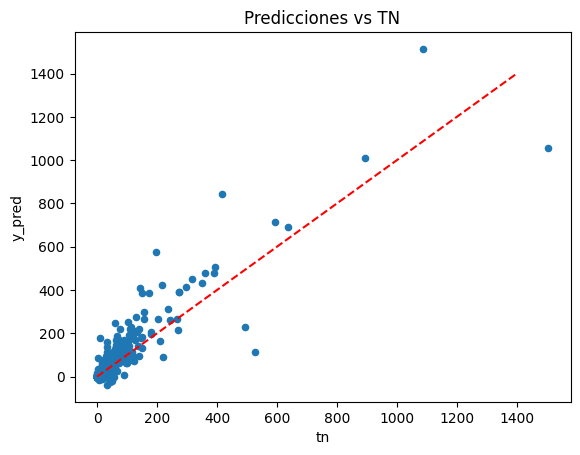

In [26]:
import matplotlib.pyplot as plt
df_final["pred_085"] = df_final["y_pred"] * 0.85
df_final.plot(kind="scatter", x="tn", y="y_pred", title="Predicciones vs TN")
plt.plot([0, 1400], [0, 1400], 'r--')
plt.show()

In [27]:
print(df_final["y_pred"].sum(),"|",df_final["tn"].sum())

32317.901074611153 | 26217.067280000003


In [28]:
1/(df_final["y_pred"].sum()/df_final["tn"].sum())

np.float64(0.8112243186670329)

In [29]:
df_final["y_pred"].sum()*0.865

np.float64(27954.984429538647)

In [30]:
sellin = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

C:\Users\carre\AppData\Local\Temp\ipykernel_8536\621086552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')


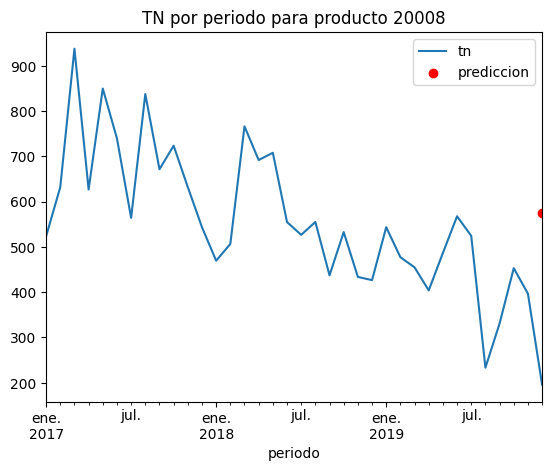

In [31]:


prod = 20008
prod_s = sellin[sellin["product_id"] == prod]
prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')
prod_s = prod_s.groupby("periodo").agg({"tn": "sum"}).reset_index()
#prod_s.plot(kind="line", x="periodo", y="tn", title="TN por periodo para producto 20002")

import matplotlib.pyplot as plt

ax = plt.gca()
prod_s.plot(kind="line", x="periodo", y="tn", title=f"TN por periodo para producto {prod}", ax=ax)
#plt.axhline(y=813.82, color='red', linestyle='--', label='predict')
prediccion = df_final[df_final["product_id"] == prod]["y_pred"].values[0]
plt.scatter(prod_s["periodo"].iloc[-1], prediccion, color='red', label='prediccion')
plt.legend()
plt.show()

In [32]:
df_final["error"] = (df_final["tn"] - df_final["y_pred"]).abs()
df_final["error_relativo"] = df_final["error"] / df_final["tn"]
df_final.sort_values(by="error", ascending=False, inplace=True)

In [33]:
df_final

,periodo,product_id,tn,y_pred,pred_085,error,error_relativo
0,201912,20001,1504.68856,1055.826788,897.452770,448.861772,0.298309
1,201912,20002,1087.30855,1514.364690,1287.209986,427.056140,0.392764
5,201912,20006,417.23228,843.885093,717.302329,426.652813,1.022579
31,201912,20032,527.79811,112.620974,95.727828,415.177136,0.786621
7,201912,20008,195.36854,574.710667,488.504067,379.342127,1.941675
...,...,...,...,...,...,...,...
912,201912,21247,0.14544,NaN,NaN,NaN,NaN
915,201912,21255,0.00328,NaN,NaN,NaN,NaN
917,201912,21257,0.01158,NaN,NaN,NaN,NaN
921,201912,21264,0.00890,NaN,NaN,NaN,NaN
